In [1]:
%matplotlib inline
import cv2 as cv
import os 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import shutil
import random

In [2]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense
from keras.preprocessing import image as kimage
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.applications import mobilenet_v2
from keras.applications import vgg16
from keras.applications import resnet50

Using TensorFlow backend.


In [11]:
#scaricare da github
face_detector = cv.CascadeClassifier('haarcascade_frontalface_default.xml')

In [32]:
os.makedirs('./ImageRec')

In [31]:
root_dir = './ImageRec'

In [6]:
def video_to_img(video_path, n_class):
    
    cam = cv.VideoCapture(video_path)
    os.makedirs('./ImageRec/' + n_class)
    currentframe = 0
    
    while(True): 
        
        ret,frame = cam.read() 
        if ret: 
            faces = face_detector.detectMultiScale(frame) 
            if len(faces) == 1:
                for (x,y,w,h) in faces:
                    face = frame[y:y+h,x:x+h,:]
                face=cv.resize(face, (224,224)) #lasciare o togliere?    
                name = './ImageRec/'+ n_class + '/frame' + str(currentframe) + '.jpg'
                print ('Creating...' + name) 
  
                cv.imwrite(name, face) 
  
            currentframe += 1
        else: 
            break
  
    cam.release() 
    cv.destroyAllWindows() 
    
    

Inserire un video con il volto da riconoscere e il numero della classe (numero della persona da riconoscere)

In [7]:
video_to_img('videom.mp4', 'classe1')

Creating..../ImageRec/classe1/frame0.jpg
Creating..../ImageRec/classe1/frame1.jpg
Creating..../ImageRec/classe1/frame2.jpg
Creating..../ImageRec/classe1/frame3.jpg
Creating..../ImageRec/classe1/frame4.jpg
Creating..../ImageRec/classe1/frame5.jpg
Creating..../ImageRec/classe1/frame6.jpg
Creating..../ImageRec/classe1/frame10.jpg
Creating..../ImageRec/classe1/frame11.jpg
Creating..../ImageRec/classe1/frame13.jpg
Creating..../ImageRec/classe1/frame14.jpg
Creating..../ImageRec/classe1/frame15.jpg
Creating..../ImageRec/classe1/frame16.jpg
Creating..../ImageRec/classe1/frame17.jpg
Creating..../ImageRec/classe1/frame18.jpg
Creating..../ImageRec/classe1/frame19.jpg
Creating..../ImageRec/classe1/frame20.jpg
Creating..../ImageRec/classe1/frame21.jpg
Creating..../ImageRec/classe1/frame22.jpg
Creating..../ImageRec/classe1/frame23.jpg
Creating..../ImageRec/classe1/frame24.jpg
Creating..../ImageRec/classe1/frame25.jpg
Creating..../ImageRec/classe1/frame26.jpg
Creating..../ImageRec/classe1/frame27.jpg

Creating..../ImageRec/classe1/frame211.jpg
Creating..../ImageRec/classe1/frame213.jpg
Creating..../ImageRec/classe1/frame214.jpg
Creating..../ImageRec/classe1/frame215.jpg
Creating..../ImageRec/classe1/frame216.jpg
Creating..../ImageRec/classe1/frame217.jpg
Creating..../ImageRec/classe1/frame218.jpg
Creating..../ImageRec/classe1/frame219.jpg
Creating..../ImageRec/classe1/frame220.jpg
Creating..../ImageRec/classe1/frame221.jpg
Creating..../ImageRec/classe1/frame222.jpg
Creating..../ImageRec/classe1/frame223.jpg
Creating..../ImageRec/classe1/frame224.jpg
Creating..../ImageRec/classe1/frame225.jpg
Creating..../ImageRec/classe1/frame226.jpg
Creating..../ImageRec/classe1/frame227.jpg
Creating..../ImageRec/classe1/frame228.jpg
Creating..../ImageRec/classe1/frame229.jpg
Creating..../ImageRec/classe1/frame230.jpg
Creating..../ImageRec/classe1/frame231.jpg
Creating..../ImageRec/classe1/frame232.jpg
Creating..../ImageRec/classe1/frame233.jpg
Creating..../ImageRec/classe1/frame234.jpg
Creating...

Creating..../ImageRec/classe1/frame420.jpg
Creating..../ImageRec/classe1/frame421.jpg
Creating..../ImageRec/classe1/frame422.jpg
Creating..../ImageRec/classe1/frame423.jpg
Creating..../ImageRec/classe1/frame424.jpg
Creating..../ImageRec/classe1/frame425.jpg
Creating..../ImageRec/classe1/frame426.jpg
Creating..../ImageRec/classe1/frame427.jpg
Creating..../ImageRec/classe1/frame429.jpg
Creating..../ImageRec/classe1/frame430.jpg
Creating..../ImageRec/classe1/frame431.jpg
Creating..../ImageRec/classe1/frame432.jpg
Creating..../ImageRec/classe1/frame434.jpg
Creating..../ImageRec/classe1/frame435.jpg
Creating..../ImageRec/classe1/frame436.jpg
Creating..../ImageRec/classe1/frame437.jpg
Creating..../ImageRec/classe1/frame438.jpg
Creating..../ImageRec/classe1/frame439.jpg
Creating..../ImageRec/classe1/frame440.jpg
Creating..../ImageRec/classe1/frame441.jpg
Creating..../ImageRec/classe1/frame442.jpg
Creating..../ImageRec/classe1/frame443.jpg
Creating..../ImageRec/classe1/frame444.jpg
Creating...

Creating..../ImageRec/classe1/frame623.jpg
Creating..../ImageRec/classe1/frame624.jpg
Creating..../ImageRec/classe1/frame625.jpg
Creating..../ImageRec/classe1/frame626.jpg
Creating..../ImageRec/classe1/frame627.jpg
Creating..../ImageRec/classe1/frame628.jpg
Creating..../ImageRec/classe1/frame629.jpg
Creating..../ImageRec/classe1/frame630.jpg
Creating..../ImageRec/classe1/frame631.jpg
Creating..../ImageRec/classe1/frame632.jpg
Creating..../ImageRec/classe1/frame633.jpg
Creating..../ImageRec/classe1/frame634.jpg
Creating..../ImageRec/classe1/frame635.jpg
Creating..../ImageRec/classe1/frame636.jpg
Creating..../ImageRec/classe1/frame637.jpg
Creating..../ImageRec/classe1/frame638.jpg
Creating..../ImageRec/classe1/frame639.jpg
Creating..../ImageRec/classe1/frame640.jpg
Creating..../ImageRec/classe1/frame641.jpg
Creating..../ImageRec/classe1/frame642.jpg
Creating..../ImageRec/classe1/frame643.jpg
Creating..../ImageRec/classe1/frame644.jpg
Creating..../ImageRec/classe1/frame645.jpg
Creating...

Creating..../ImageRec/classe1/frame817.jpg
Creating..../ImageRec/classe1/frame818.jpg
Creating..../ImageRec/classe1/frame819.jpg
Creating..../ImageRec/classe1/frame820.jpg
Creating..../ImageRec/classe1/frame821.jpg
Creating..../ImageRec/classe1/frame822.jpg
Creating..../ImageRec/classe1/frame823.jpg
Creating..../ImageRec/classe1/frame824.jpg
Creating..../ImageRec/classe1/frame825.jpg
Creating..../ImageRec/classe1/frame826.jpg
Creating..../ImageRec/classe1/frame827.jpg
Creating..../ImageRec/classe1/frame828.jpg
Creating..../ImageRec/classe1/frame829.jpg
Creating..../ImageRec/classe1/frame830.jpg
Creating..../ImageRec/classe1/frame831.jpg
Creating..../ImageRec/classe1/frame832.jpg
Creating..../ImageRec/classe1/frame833.jpg
Creating..../ImageRec/classe1/frame834.jpg
Creating..../ImageRec/classe1/frame835.jpg
Creating..../ImageRec/classe1/frame836.jpg
Creating..../ImageRec/classe1/frame837.jpg
Creating..../ImageRec/classe1/frame838.jpg
Creating..../ImageRec/classe1/frame839.jpg
Creating...

Creating..../ImageRec/classe1/frame1037.jpg
Creating..../ImageRec/classe1/frame1038.jpg
Creating..../ImageRec/classe1/frame1039.jpg
Creating..../ImageRec/classe1/frame1040.jpg


In [8]:
video_to_img('roberto_video_faccia.webm', 'classe2')

Creating..../ImageRec/classe2/frame0.jpg
Creating..../ImageRec/classe2/frame1.jpg
Creating..../ImageRec/classe2/frame2.jpg
Creating..../ImageRec/classe2/frame3.jpg
Creating..../ImageRec/classe2/frame4.jpg
Creating..../ImageRec/classe2/frame5.jpg
Creating..../ImageRec/classe2/frame6.jpg
Creating..../ImageRec/classe2/frame7.jpg
Creating..../ImageRec/classe2/frame8.jpg
Creating..../ImageRec/classe2/frame9.jpg
Creating..../ImageRec/classe2/frame10.jpg
Creating..../ImageRec/classe2/frame11.jpg
Creating..../ImageRec/classe2/frame12.jpg
Creating..../ImageRec/classe2/frame13.jpg
Creating..../ImageRec/classe2/frame14.jpg
Creating..../ImageRec/classe2/frame15.jpg
Creating..../ImageRec/classe2/frame16.jpg
Creating..../ImageRec/classe2/frame17.jpg
Creating..../ImageRec/classe2/frame18.jpg
Creating..../ImageRec/classe2/frame19.jpg
Creating..../ImageRec/classe2/frame20.jpg
Creating..../ImageRec/classe2/frame21.jpg
Creating..../ImageRec/classe2/frame22.jpg
Creating..../ImageRec/classe2/frame23.jpg
Cr

Creating..../ImageRec/classe2/frame200.jpg
Creating..../ImageRec/classe2/frame201.jpg
Creating..../ImageRec/classe2/frame202.jpg
Creating..../ImageRec/classe2/frame203.jpg
Creating..../ImageRec/classe2/frame204.jpg
Creating..../ImageRec/classe2/frame205.jpg
Creating..../ImageRec/classe2/frame206.jpg
Creating..../ImageRec/classe2/frame207.jpg
Creating..../ImageRec/classe2/frame208.jpg
Creating..../ImageRec/classe2/frame209.jpg
Creating..../ImageRec/classe2/frame210.jpg
Creating..../ImageRec/classe2/frame211.jpg
Creating..../ImageRec/classe2/frame212.jpg
Creating..../ImageRec/classe2/frame213.jpg
Creating..../ImageRec/classe2/frame214.jpg
Creating..../ImageRec/classe2/frame215.jpg
Creating..../ImageRec/classe2/frame216.jpg
Creating..../ImageRec/classe2/frame217.jpg
Creating..../ImageRec/classe2/frame218.jpg
Creating..../ImageRec/classe2/frame219.jpg
Creating..../ImageRec/classe2/frame220.jpg
Creating..../ImageRec/classe2/frame221.jpg
Creating..../ImageRec/classe2/frame222.jpg
Creating...

Creating..../ImageRec/classe2/frame435.jpg
Creating..../ImageRec/classe2/frame441.jpg
Creating..../ImageRec/classe2/frame453.jpg
Creating..../ImageRec/classe2/frame454.jpg
Creating..../ImageRec/classe2/frame456.jpg
Creating..../ImageRec/classe2/frame457.jpg
Creating..../ImageRec/classe2/frame459.jpg
Creating..../ImageRec/classe2/frame460.jpg
Creating..../ImageRec/classe2/frame461.jpg
Creating..../ImageRec/classe2/frame462.jpg
Creating..../ImageRec/classe2/frame463.jpg
Creating..../ImageRec/classe2/frame464.jpg
Creating..../ImageRec/classe2/frame465.jpg
Creating..../ImageRec/classe2/frame466.jpg
Creating..../ImageRec/classe2/frame467.jpg
Creating..../ImageRec/classe2/frame468.jpg
Creating..../ImageRec/classe2/frame469.jpg
Creating..../ImageRec/classe2/frame470.jpg
Creating..../ImageRec/classe2/frame471.jpg
Creating..../ImageRec/classe2/frame472.jpg
Creating..../ImageRec/classe2/frame473.jpg
Creating..../ImageRec/classe2/frame474.jpg
Creating..../ImageRec/classe2/frame475.jpg
Creating...

Creating..../ImageRec/classe2/frame664.jpg
Creating..../ImageRec/classe2/frame665.jpg
Creating..../ImageRec/classe2/frame666.jpg
Creating..../ImageRec/classe2/frame667.jpg
Creating..../ImageRec/classe2/frame668.jpg
Creating..../ImageRec/classe2/frame669.jpg
Creating..../ImageRec/classe2/frame670.jpg
Creating..../ImageRec/classe2/frame671.jpg
Creating..../ImageRec/classe2/frame672.jpg
Creating..../ImageRec/classe2/frame673.jpg
Creating..../ImageRec/classe2/frame674.jpg
Creating..../ImageRec/classe2/frame675.jpg
Creating..../ImageRec/classe2/frame676.jpg
Creating..../ImageRec/classe2/frame677.jpg
Creating..../ImageRec/classe2/frame678.jpg
Creating..../ImageRec/classe2/frame680.jpg
Creating..../ImageRec/classe2/frame681.jpg
Creating..../ImageRec/classe2/frame682.jpg
Creating..../ImageRec/classe2/frame683.jpg
Creating..../ImageRec/classe2/frame684.jpg
Creating..../ImageRec/classe2/frame685.jpg
Creating..../ImageRec/classe2/frame686.jpg
Creating..../ImageRec/classe2/frame687.jpg
Creating...

Creating..../ImageRec/classe2/frame881.jpg
Creating..../ImageRec/classe2/frame884.jpg
Creating..../ImageRec/classe2/frame885.jpg
Creating..../ImageRec/classe2/frame886.jpg
Creating..../ImageRec/classe2/frame887.jpg
Creating..../ImageRec/classe2/frame888.jpg
Creating..../ImageRec/classe2/frame889.jpg
Creating..../ImageRec/classe2/frame890.jpg
Creating..../ImageRec/classe2/frame891.jpg
Creating..../ImageRec/classe2/frame892.jpg
Creating..../ImageRec/classe2/frame893.jpg
Creating..../ImageRec/classe2/frame894.jpg
Creating..../ImageRec/classe2/frame895.jpg
Creating..../ImageRec/classe2/frame897.jpg
Creating..../ImageRec/classe2/frame898.jpg
Creating..../ImageRec/classe2/frame899.jpg
Creating..../ImageRec/classe2/frame900.jpg
Creating..../ImageRec/classe2/frame901.jpg
Creating..../ImageRec/classe2/frame902.jpg
Creating..../ImageRec/classe2/frame903.jpg
Creating..../ImageRec/classe2/frame904.jpg
Creating..../ImageRec/classe2/frame905.jpg
Creating..../ImageRec/classe2/frame906.jpg
Creating...

Creating..../ImageRec/classe2/frame1073.jpg
Creating..../ImageRec/classe2/frame1074.jpg
Creating..../ImageRec/classe2/frame1075.jpg
Creating..../ImageRec/classe2/frame1076.jpg
Creating..../ImageRec/classe2/frame1077.jpg
Creating..../ImageRec/classe2/frame1078.jpg
Creating..../ImageRec/classe2/frame1079.jpg
Creating..../ImageRec/classe2/frame1080.jpg
Creating..../ImageRec/classe2/frame1081.jpg
Creating..../ImageRec/classe2/frame1082.jpg
Creating..../ImageRec/classe2/frame1083.jpg
Creating..../ImageRec/classe2/frame1084.jpg
Creating..../ImageRec/classe2/frame1085.jpg
Creating..../ImageRec/classe2/frame1086.jpg
Creating..../ImageRec/classe2/frame1087.jpg
Creating..../ImageRec/classe2/frame1088.jpg
Creating..../ImageRec/classe2/frame1089.jpg
Creating..../ImageRec/classe2/frame1090.jpg
Creating..../ImageRec/classe2/frame1091.jpg
Creating..../ImageRec/classe2/frame1092.jpg
Creating..../ImageRec/classe2/frame1093.jpg
Creating..../ImageRec/classe2/frame1094.jpg
Creating..../ImageRec/classe2/fr

In [9]:
#video_to_img('classe3.mp4', 'classe3')

Creating..../ImageRec/classe3/frame0.jpg
Creating..../ImageRec/classe3/frame1.jpg
Creating..../ImageRec/classe3/frame2.jpg
Creating..../ImageRec/classe3/frame3.jpg
Creating..../ImageRec/classe3/frame4.jpg
Creating..../ImageRec/classe3/frame5.jpg
Creating..../ImageRec/classe3/frame6.jpg
Creating..../ImageRec/classe3/frame7.jpg
Creating..../ImageRec/classe3/frame8.jpg
Creating..../ImageRec/classe3/frame9.jpg
Creating..../ImageRec/classe3/frame10.jpg
Creating..../ImageRec/classe3/frame11.jpg
Creating..../ImageRec/classe3/frame12.jpg
Creating..../ImageRec/classe3/frame14.jpg
Creating..../ImageRec/classe3/frame15.jpg
Creating..../ImageRec/classe3/frame16.jpg
Creating..../ImageRec/classe3/frame17.jpg
Creating..../ImageRec/classe3/frame18.jpg
Creating..../ImageRec/classe3/frame19.jpg
Creating..../ImageRec/classe3/frame20.jpg
Creating..../ImageRec/classe3/frame22.jpg
Creating..../ImageRec/classe3/frame23.jpg
Creating..../ImageRec/classe3/frame24.jpg
Creating..../ImageRec/classe3/frame25.jpg
Cr

Creating..../ImageRec/classe3/frame249.jpg
Creating..../ImageRec/classe3/frame250.jpg
Creating..../ImageRec/classe3/frame251.jpg
Creating..../ImageRec/classe3/frame253.jpg
Creating..../ImageRec/classe3/frame267.jpg
Creating..../ImageRec/classe3/frame268.jpg
Creating..../ImageRec/classe3/frame270.jpg
Creating..../ImageRec/classe3/frame272.jpg
Creating..../ImageRec/classe3/frame275.jpg
Creating..../ImageRec/classe3/frame280.jpg
Creating..../ImageRec/classe3/frame281.jpg
Creating..../ImageRec/classe3/frame282.jpg
Creating..../ImageRec/classe3/frame285.jpg
Creating..../ImageRec/classe3/frame286.jpg
Creating..../ImageRec/classe3/frame287.jpg
Creating..../ImageRec/classe3/frame289.jpg
Creating..../ImageRec/classe3/frame292.jpg
Creating..../ImageRec/classe3/frame293.jpg
Creating..../ImageRec/classe3/frame294.jpg
Creating..../ImageRec/classe3/frame295.jpg
Creating..../ImageRec/classe3/frame296.jpg
Creating..../ImageRec/classe3/frame297.jpg
Creating..../ImageRec/classe3/frame298.jpg
Creating...

Creating..../ImageRec/classe3/frame543.jpg
Creating..../ImageRec/classe3/frame544.jpg
Creating..../ImageRec/classe3/frame545.jpg
Creating..../ImageRec/classe3/frame546.jpg
Creating..../ImageRec/classe3/frame547.jpg
Creating..../ImageRec/classe3/frame548.jpg
Creating..../ImageRec/classe3/frame549.jpg
Creating..../ImageRec/classe3/frame550.jpg
Creating..../ImageRec/classe3/frame551.jpg
Creating..../ImageRec/classe3/frame552.jpg
Creating..../ImageRec/classe3/frame553.jpg
Creating..../ImageRec/classe3/frame554.jpg
Creating..../ImageRec/classe3/frame555.jpg
Creating..../ImageRec/classe3/frame556.jpg
Creating..../ImageRec/classe3/frame557.jpg
Creating..../ImageRec/classe3/frame558.jpg
Creating..../ImageRec/classe3/frame559.jpg
Creating..../ImageRec/classe3/frame560.jpg
Creating..../ImageRec/classe3/frame561.jpg
Creating..../ImageRec/classe3/frame562.jpg
Creating..../ImageRec/classe3/frame563.jpg
Creating..../ImageRec/classe3/frame567.jpg
Creating..../ImageRec/classe3/frame568.jpg
Creating...

In [10]:
def augment_brightness_camera_images(image):
    image1 = cv.cvtColor(image,cv.COLOR_RGB2HSV)
    random_bright = 0.25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv.cvtColor(image1,cv.COLOR_HSV2RGB)
    return image1

def transform_image(img,ang_range,shear_range,trans_range,brightness=0):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    # Brightness


    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv.getAffineTransform(pts1,pts2)

    img = cv.warpAffine(img,Rot_M,(cols,rows))
    img = cv.warpAffine(img,Trans_M,(cols,rows))
    img = cv.warpAffine(img,shear_M,(cols,rows))

    if brightness == 1:
        img = augment_brightness_camera_images(img)

    return img

In [11]:
def image_augmentation(path):
    for foto in os.listdir(path):
        img = mpimg.imread(os.path.join(path, foto))
        for i in range(2):
            imgg = transform_image(img,10,5,3,brightness=1)
            copia_foto = path + '/' + foto.rpartition('.jpg')[0] + 'copia' + str(i+1) + '.jpg'
            mpimg.imsave(copia_foto, imgg)
            print ('Creating...' + copia_foto ) 
    

In [12]:
#image_augmentation('./ImageRec/classe1')

In [13]:
for subdir in os.listdir(root_dir):
    image_augmentation(os.path.join(root_dir, subdir))

Creating..../ImageRec\classe1/frame0copia1.jpg
Creating..../ImageRec\classe1/frame0copia2.jpg
Creating..../ImageRec\classe1/frame1copia1.jpg
Creating..../ImageRec\classe1/frame1copia2.jpg
Creating..../ImageRec\classe1/frame10copia1.jpg
Creating..../ImageRec\classe1/frame10copia2.jpg
Creating..../ImageRec\classe1/frame100copia1.jpg
Creating..../ImageRec\classe1/frame100copia2.jpg
Creating..../ImageRec\classe1/frame1004copia1.jpg
Creating..../ImageRec\classe1/frame1004copia2.jpg
Creating..../ImageRec\classe1/frame1006copia1.jpg
Creating..../ImageRec\classe1/frame1006copia2.jpg
Creating..../ImageRec\classe1/frame1007copia1.jpg
Creating..../ImageRec\classe1/frame1007copia2.jpg
Creating..../ImageRec\classe1/frame1008copia1.jpg
Creating..../ImageRec\classe1/frame1008copia2.jpg
Creating..../ImageRec\classe1/frame1009copia1.jpg
Creating..../ImageRec\classe1/frame1009copia2.jpg
Creating..../ImageRec\classe1/frame101copia1.jpg
Creating..../ImageRec\classe1/frame101copia2.jpg
Creating..../ImageRe

Creating..../ImageRec\classe1/frame172copia2.jpg
Creating..../ImageRec\classe1/frame173copia1.jpg
Creating..../ImageRec\classe1/frame173copia2.jpg
Creating..../ImageRec\classe1/frame174copia1.jpg
Creating..../ImageRec\classe1/frame174copia2.jpg
Creating..../ImageRec\classe1/frame175copia1.jpg
Creating..../ImageRec\classe1/frame175copia2.jpg
Creating..../ImageRec\classe1/frame176copia1.jpg
Creating..../ImageRec\classe1/frame176copia2.jpg
Creating..../ImageRec\classe1/frame177copia1.jpg
Creating..../ImageRec\classe1/frame177copia2.jpg
Creating..../ImageRec\classe1/frame178copia1.jpg
Creating..../ImageRec\classe1/frame178copia2.jpg
Creating..../ImageRec\classe1/frame179copia1.jpg
Creating..../ImageRec\classe1/frame179copia2.jpg
Creating..../ImageRec\classe1/frame18copia1.jpg
Creating..../ImageRec\classe1/frame18copia2.jpg
Creating..../ImageRec\classe1/frame180copia1.jpg
Creating..../ImageRec\classe1/frame180copia2.jpg
Creating..../ImageRec\classe1/frame181copia1.jpg
Creating..../ImageRec\

Creating..../ImageRec\classe1/frame261copia2.jpg
Creating..../ImageRec\classe1/frame262copia1.jpg
Creating..../ImageRec\classe1/frame262copia2.jpg
Creating..../ImageRec\classe1/frame263copia1.jpg
Creating..../ImageRec\classe1/frame263copia2.jpg
Creating..../ImageRec\classe1/frame264copia1.jpg
Creating..../ImageRec\classe1/frame264copia2.jpg
Creating..../ImageRec\classe1/frame265copia1.jpg
Creating..../ImageRec\classe1/frame265copia2.jpg
Creating..../ImageRec\classe1/frame266copia1.jpg
Creating..../ImageRec\classe1/frame266copia2.jpg
Creating..../ImageRec\classe1/frame267copia1.jpg
Creating..../ImageRec\classe1/frame267copia2.jpg
Creating..../ImageRec\classe1/frame268copia1.jpg
Creating..../ImageRec\classe1/frame268copia2.jpg
Creating..../ImageRec\classe1/frame269copia1.jpg
Creating..../ImageRec\classe1/frame269copia2.jpg
Creating..../ImageRec\classe1/frame27copia1.jpg
Creating..../ImageRec\classe1/frame27copia2.jpg
Creating..../ImageRec\classe1/frame270copia1.jpg
Creating..../ImageRec\

Creating..../ImageRec\classe1/frame353copia2.jpg
Creating..../ImageRec\classe1/frame354copia1.jpg
Creating..../ImageRec\classe1/frame354copia2.jpg
Creating..../ImageRec\classe1/frame356copia1.jpg
Creating..../ImageRec\classe1/frame356copia2.jpg
Creating..../ImageRec\classe1/frame357copia1.jpg
Creating..../ImageRec\classe1/frame357copia2.jpg
Creating..../ImageRec\classe1/frame359copia1.jpg
Creating..../ImageRec\classe1/frame359copia2.jpg
Creating..../ImageRec\classe1/frame36copia1.jpg
Creating..../ImageRec\classe1/frame36copia2.jpg
Creating..../ImageRec\classe1/frame360copia1.jpg
Creating..../ImageRec\classe1/frame360copia2.jpg
Creating..../ImageRec\classe1/frame361copia1.jpg
Creating..../ImageRec\classe1/frame361copia2.jpg
Creating..../ImageRec\classe1/frame362copia1.jpg
Creating..../ImageRec\classe1/frame362copia2.jpg
Creating..../ImageRec\classe1/frame363copia1.jpg
Creating..../ImageRec\classe1/frame363copia2.jpg
Creating..../ImageRec\classe1/frame364copia1.jpg
Creating..../ImageRec\

Creating..../ImageRec\classe1/frame451copia2.jpg
Creating..../ImageRec\classe1/frame452copia1.jpg
Creating..../ImageRec\classe1/frame452copia2.jpg
Creating..../ImageRec\classe1/frame453copia1.jpg
Creating..../ImageRec\classe1/frame453copia2.jpg
Creating..../ImageRec\classe1/frame454copia1.jpg
Creating..../ImageRec\classe1/frame454copia2.jpg
Creating..../ImageRec\classe1/frame455copia1.jpg
Creating..../ImageRec\classe1/frame455copia2.jpg
Creating..../ImageRec\classe1/frame456copia1.jpg
Creating..../ImageRec\classe1/frame456copia2.jpg
Creating..../ImageRec\classe1/frame457copia1.jpg
Creating..../ImageRec\classe1/frame457copia2.jpg
Creating..../ImageRec\classe1/frame458copia1.jpg
Creating..../ImageRec\classe1/frame458copia2.jpg
Creating..../ImageRec\classe1/frame459copia1.jpg
Creating..../ImageRec\classe1/frame459copia2.jpg
Creating..../ImageRec\classe1/frame46copia1.jpg
Creating..../ImageRec\classe1/frame46copia2.jpg
Creating..../ImageRec\classe1/frame460copia1.jpg
Creating..../ImageRec\

Creating..../ImageRec\classe1/frame540copia1.jpg
Creating..../ImageRec\classe1/frame540copia2.jpg
Creating..../ImageRec\classe1/frame541copia1.jpg
Creating..../ImageRec\classe1/frame541copia2.jpg
Creating..../ImageRec\classe1/frame542copia1.jpg
Creating..../ImageRec\classe1/frame542copia2.jpg
Creating..../ImageRec\classe1/frame543copia1.jpg
Creating..../ImageRec\classe1/frame543copia2.jpg
Creating..../ImageRec\classe1/frame544copia1.jpg
Creating..../ImageRec\classe1/frame544copia2.jpg
Creating..../ImageRec\classe1/frame545copia1.jpg
Creating..../ImageRec\classe1/frame545copia2.jpg
Creating..../ImageRec\classe1/frame546copia1.jpg
Creating..../ImageRec\classe1/frame546copia2.jpg
Creating..../ImageRec\classe1/frame547copia1.jpg
Creating..../ImageRec\classe1/frame547copia2.jpg
Creating..../ImageRec\classe1/frame549copia1.jpg
Creating..../ImageRec\classe1/frame549copia2.jpg
Creating..../ImageRec\classe1/frame55copia1.jpg
Creating..../ImageRec\classe1/frame55copia2.jpg
Creating..../ImageRec\

Creating..../ImageRec\classe1/frame624copia1.jpg
Creating..../ImageRec\classe1/frame624copia2.jpg
Creating..../ImageRec\classe1/frame625copia1.jpg
Creating..../ImageRec\classe1/frame625copia2.jpg
Creating..../ImageRec\classe1/frame626copia1.jpg
Creating..../ImageRec\classe1/frame626copia2.jpg
Creating..../ImageRec\classe1/frame627copia1.jpg
Creating..../ImageRec\classe1/frame627copia2.jpg
Creating..../ImageRec\classe1/frame628copia1.jpg
Creating..../ImageRec\classe1/frame628copia2.jpg
Creating..../ImageRec\classe1/frame629copia1.jpg
Creating..../ImageRec\classe1/frame629copia2.jpg
Creating..../ImageRec\classe1/frame63copia1.jpg
Creating..../ImageRec\classe1/frame63copia2.jpg
Creating..../ImageRec\classe1/frame630copia1.jpg
Creating..../ImageRec\classe1/frame630copia2.jpg
Creating..../ImageRec\classe1/frame631copia1.jpg
Creating..../ImageRec\classe1/frame631copia2.jpg
Creating..../ImageRec\classe1/frame632copia1.jpg
Creating..../ImageRec\classe1/frame632copia2.jpg
Creating..../ImageRec\

Creating..../ImageRec\classe1/frame715copia2.jpg
Creating..../ImageRec\classe1/frame716copia1.jpg
Creating..../ImageRec\classe1/frame716copia2.jpg
Creating..../ImageRec\classe1/frame717copia1.jpg
Creating..../ImageRec\classe1/frame717copia2.jpg
Creating..../ImageRec\classe1/frame718copia1.jpg
Creating..../ImageRec\classe1/frame718copia2.jpg
Creating..../ImageRec\classe1/frame719copia1.jpg
Creating..../ImageRec\classe1/frame719copia2.jpg
Creating..../ImageRec\classe1/frame72copia1.jpg
Creating..../ImageRec\classe1/frame72copia2.jpg
Creating..../ImageRec\classe1/frame720copia1.jpg
Creating..../ImageRec\classe1/frame720copia2.jpg
Creating..../ImageRec\classe1/frame721copia1.jpg
Creating..../ImageRec\classe1/frame721copia2.jpg
Creating..../ImageRec\classe1/frame722copia1.jpg
Creating..../ImageRec\classe1/frame722copia2.jpg
Creating..../ImageRec\classe1/frame723copia1.jpg
Creating..../ImageRec\classe1/frame723copia2.jpg
Creating..../ImageRec\classe1/frame724copia1.jpg
Creating..../ImageRec\

Creating..../ImageRec\classe1/frame802copia1.jpg
Creating..../ImageRec\classe1/frame802copia2.jpg
Creating..../ImageRec\classe1/frame803copia1.jpg
Creating..../ImageRec\classe1/frame803copia2.jpg
Creating..../ImageRec\classe1/frame804copia1.jpg
Creating..../ImageRec\classe1/frame804copia2.jpg
Creating..../ImageRec\classe1/frame805copia1.jpg
Creating..../ImageRec\classe1/frame805copia2.jpg
Creating..../ImageRec\classe1/frame806copia1.jpg
Creating..../ImageRec\classe1/frame806copia2.jpg
Creating..../ImageRec\classe1/frame807copia1.jpg
Creating..../ImageRec\classe1/frame807copia2.jpg
Creating..../ImageRec\classe1/frame808copia1.jpg
Creating..../ImageRec\classe1/frame808copia2.jpg
Creating..../ImageRec\classe1/frame809copia1.jpg
Creating..../ImageRec\classe1/frame809copia2.jpg
Creating..../ImageRec\classe1/frame81copia1.jpg
Creating..../ImageRec\classe1/frame81copia2.jpg
Creating..../ImageRec\classe1/frame810copia1.jpg
Creating..../ImageRec\classe1/frame810copia2.jpg
Creating..../ImageRec\

Creating..../ImageRec\classe1/frame89copia1.jpg
Creating..../ImageRec\classe1/frame89copia2.jpg
Creating..../ImageRec\classe1/frame890copia1.jpg
Creating..../ImageRec\classe1/frame890copia2.jpg
Creating..../ImageRec\classe1/frame891copia1.jpg
Creating..../ImageRec\classe1/frame891copia2.jpg
Creating..../ImageRec\classe1/frame892copia1.jpg
Creating..../ImageRec\classe1/frame892copia2.jpg
Creating..../ImageRec\classe1/frame893copia1.jpg
Creating..../ImageRec\classe1/frame893copia2.jpg
Creating..../ImageRec\classe1/frame894copia1.jpg
Creating..../ImageRec\classe1/frame894copia2.jpg
Creating..../ImageRec\classe1/frame895copia1.jpg
Creating..../ImageRec\classe1/frame895copia2.jpg
Creating..../ImageRec\classe1/frame896copia1.jpg
Creating..../ImageRec\classe1/frame896copia2.jpg
Creating..../ImageRec\classe1/frame897copia1.jpg
Creating..../ImageRec\classe1/frame897copia2.jpg
Creating..../ImageRec\classe1/frame898copia1.jpg
Creating..../ImageRec\classe1/frame898copia2.jpg
Creating..../ImageRec\

Creating..../ImageRec\classe1/frame977copia2.jpg
Creating..../ImageRec\classe1/frame978copia1.jpg
Creating..../ImageRec\classe1/frame978copia2.jpg
Creating..../ImageRec\classe1/frame979copia1.jpg
Creating..../ImageRec\classe1/frame979copia2.jpg
Creating..../ImageRec\classe1/frame98copia1.jpg
Creating..../ImageRec\classe1/frame98copia2.jpg
Creating..../ImageRec\classe1/frame980copia1.jpg
Creating..../ImageRec\classe1/frame980copia2.jpg
Creating..../ImageRec\classe1/frame981copia1.jpg
Creating..../ImageRec\classe1/frame981copia2.jpg
Creating..../ImageRec\classe1/frame982copia1.jpg
Creating..../ImageRec\classe1/frame982copia2.jpg
Creating..../ImageRec\classe1/frame983copia1.jpg
Creating..../ImageRec\classe1/frame983copia2.jpg
Creating..../ImageRec\classe1/frame985copia1.jpg
Creating..../ImageRec\classe1/frame985copia2.jpg
Creating..../ImageRec\classe1/frame986copia1.jpg
Creating..../ImageRec\classe1/frame986copia2.jpg
Creating..../ImageRec\classe1/frame988copia1.jpg
Creating..../ImageRec\

Creating..../ImageRec\classe2/frame1068copia2.jpg
Creating..../ImageRec\classe2/frame1069copia1.jpg
Creating..../ImageRec\classe2/frame1069copia2.jpg
Creating..../ImageRec\classe2/frame107copia1.jpg
Creating..../ImageRec\classe2/frame107copia2.jpg
Creating..../ImageRec\classe2/frame1070copia1.jpg
Creating..../ImageRec\classe2/frame1070copia2.jpg
Creating..../ImageRec\classe2/frame1071copia1.jpg
Creating..../ImageRec\classe2/frame1071copia2.jpg
Creating..../ImageRec\classe2/frame1072copia1.jpg
Creating..../ImageRec\classe2/frame1072copia2.jpg
Creating..../ImageRec\classe2/frame1073copia1.jpg
Creating..../ImageRec\classe2/frame1073copia2.jpg
Creating..../ImageRec\classe2/frame1074copia1.jpg
Creating..../ImageRec\classe2/frame1074copia2.jpg
Creating..../ImageRec\classe2/frame1075copia1.jpg
Creating..../ImageRec\classe2/frame1075copia2.jpg
Creating..../ImageRec\classe2/frame1076copia1.jpg
Creating..../ImageRec\classe2/frame1076copia2.jpg
Creating..../ImageRec\classe2/frame1077copia1.jpg
Cr

Creating..../ImageRec\classe2/frame1156copia1.jpg
Creating..../ImageRec\classe2/frame1156copia2.jpg
Creating..../ImageRec\classe2/frame1157copia1.jpg
Creating..../ImageRec\classe2/frame1157copia2.jpg
Creating..../ImageRec\classe2/frame1158copia1.jpg
Creating..../ImageRec\classe2/frame1158copia2.jpg
Creating..../ImageRec\classe2/frame1159copia1.jpg
Creating..../ImageRec\classe2/frame1159copia2.jpg
Creating..../ImageRec\classe2/frame116copia1.jpg
Creating..../ImageRec\classe2/frame116copia2.jpg
Creating..../ImageRec\classe2/frame1160copia1.jpg
Creating..../ImageRec\classe2/frame1160copia2.jpg
Creating..../ImageRec\classe2/frame1161copia1.jpg
Creating..../ImageRec\classe2/frame1161copia2.jpg
Creating..../ImageRec\classe2/frame1162copia1.jpg
Creating..../ImageRec\classe2/frame1162copia2.jpg
Creating..../ImageRec\classe2/frame1163copia1.jpg
Creating..../ImageRec\classe2/frame1163copia2.jpg
Creating..../ImageRec\classe2/frame1164copia1.jpg
Creating..../ImageRec\classe2/frame1164copia2.jpg
Cr

Creating..../ImageRec\classe2/frame175copia2.jpg
Creating..../ImageRec\classe2/frame176copia1.jpg
Creating..../ImageRec\classe2/frame176copia2.jpg
Creating..../ImageRec\classe2/frame177copia1.jpg
Creating..../ImageRec\classe2/frame177copia2.jpg
Creating..../ImageRec\classe2/frame178copia1.jpg
Creating..../ImageRec\classe2/frame178copia2.jpg
Creating..../ImageRec\classe2/frame179copia1.jpg
Creating..../ImageRec\classe2/frame179copia2.jpg
Creating..../ImageRec\classe2/frame18copia1.jpg
Creating..../ImageRec\classe2/frame18copia2.jpg
Creating..../ImageRec\classe2/frame180copia1.jpg
Creating..../ImageRec\classe2/frame180copia2.jpg
Creating..../ImageRec\classe2/frame181copia1.jpg
Creating..../ImageRec\classe2/frame181copia2.jpg
Creating..../ImageRec\classe2/frame182copia1.jpg
Creating..../ImageRec\classe2/frame182copia2.jpg
Creating..../ImageRec\classe2/frame183copia1.jpg
Creating..../ImageRec\classe2/frame183copia2.jpg
Creating..../ImageRec\classe2/frame184copia1.jpg
Creating..../ImageRec\

Creating..../ImageRec\classe2/frame264copia1.jpg
Creating..../ImageRec\classe2/frame264copia2.jpg
Creating..../ImageRec\classe2/frame265copia1.jpg
Creating..../ImageRec\classe2/frame265copia2.jpg
Creating..../ImageRec\classe2/frame266copia1.jpg
Creating..../ImageRec\classe2/frame266copia2.jpg
Creating..../ImageRec\classe2/frame267copia1.jpg
Creating..../ImageRec\classe2/frame267copia2.jpg
Creating..../ImageRec\classe2/frame268copia1.jpg
Creating..../ImageRec\classe2/frame268copia2.jpg
Creating..../ImageRec\classe2/frame269copia1.jpg
Creating..../ImageRec\classe2/frame269copia2.jpg
Creating..../ImageRec\classe2/frame27copia1.jpg
Creating..../ImageRec\classe2/frame27copia2.jpg
Creating..../ImageRec\classe2/frame270copia1.jpg
Creating..../ImageRec\classe2/frame270copia2.jpg
Creating..../ImageRec\classe2/frame274copia1.jpg
Creating..../ImageRec\classe2/frame274copia2.jpg
Creating..../ImageRec\classe2/frame275copia1.jpg
Creating..../ImageRec\classe2/frame275copia2.jpg
Creating..../ImageRec\

Creating..../ImageRec\classe2/frame365copia2.jpg
Creating..../ImageRec\classe2/frame368copia1.jpg
Creating..../ImageRec\classe2/frame368copia2.jpg
Creating..../ImageRec\classe2/frame37copia1.jpg
Creating..../ImageRec\classe2/frame37copia2.jpg
Creating..../ImageRec\classe2/frame373copia1.jpg
Creating..../ImageRec\classe2/frame373copia2.jpg
Creating..../ImageRec\classe2/frame375copia1.jpg
Creating..../ImageRec\classe2/frame375copia2.jpg
Creating..../ImageRec\classe2/frame376copia1.jpg
Creating..../ImageRec\classe2/frame376copia2.jpg
Creating..../ImageRec\classe2/frame377copia1.jpg
Creating..../ImageRec\classe2/frame377copia2.jpg
Creating..../ImageRec\classe2/frame378copia1.jpg
Creating..../ImageRec\classe2/frame378copia2.jpg
Creating..../ImageRec\classe2/frame379copia1.jpg
Creating..../ImageRec\classe2/frame379copia2.jpg
Creating..../ImageRec\classe2/frame38copia1.jpg
Creating..../ImageRec\classe2/frame38copia2.jpg
Creating..../ImageRec\classe2/frame381copia1.jpg
Creating..../ImageRec\cl

Creating..../ImageRec\classe2/frame5copia1.jpg
Creating..../ImageRec\classe2/frame5copia2.jpg
Creating..../ImageRec\classe2/frame50copia1.jpg
Creating..../ImageRec\classe2/frame50copia2.jpg
Creating..../ImageRec\classe2/frame500copia1.jpg
Creating..../ImageRec\classe2/frame500copia2.jpg
Creating..../ImageRec\classe2/frame501copia1.jpg
Creating..../ImageRec\classe2/frame501copia2.jpg
Creating..../ImageRec\classe2/frame502copia1.jpg
Creating..../ImageRec\classe2/frame502copia2.jpg
Creating..../ImageRec\classe2/frame503copia1.jpg
Creating..../ImageRec\classe2/frame503copia2.jpg
Creating..../ImageRec\classe2/frame504copia1.jpg
Creating..../ImageRec\classe2/frame504copia2.jpg
Creating..../ImageRec\classe2/frame505copia1.jpg
Creating..../ImageRec\classe2/frame505copia2.jpg
Creating..../ImageRec\classe2/frame506copia1.jpg
Creating..../ImageRec\classe2/frame506copia2.jpg
Creating..../ImageRec\classe2/frame507copia1.jpg
Creating..../ImageRec\classe2/frame507copia2.jpg
Creating..../ImageRec\clas

Creating..../ImageRec\classe2/frame591copia2.jpg
Creating..../ImageRec\classe2/frame592copia1.jpg
Creating..../ImageRec\classe2/frame592copia2.jpg
Creating..../ImageRec\classe2/frame593copia1.jpg
Creating..../ImageRec\classe2/frame593copia2.jpg
Creating..../ImageRec\classe2/frame594copia1.jpg
Creating..../ImageRec\classe2/frame594copia2.jpg
Creating..../ImageRec\classe2/frame595copia1.jpg
Creating..../ImageRec\classe2/frame595copia2.jpg
Creating..../ImageRec\classe2/frame596copia1.jpg
Creating..../ImageRec\classe2/frame596copia2.jpg
Creating..../ImageRec\classe2/frame598copia1.jpg
Creating..../ImageRec\classe2/frame598copia2.jpg
Creating..../ImageRec\classe2/frame599copia1.jpg
Creating..../ImageRec\classe2/frame599copia2.jpg
Creating..../ImageRec\classe2/frame6copia1.jpg
Creating..../ImageRec\classe2/frame6copia2.jpg
Creating..../ImageRec\classe2/frame60copia1.jpg
Creating..../ImageRec\classe2/frame60copia2.jpg
Creating..../ImageRec\classe2/frame600copia1.jpg
Creating..../ImageRec\clas

Creating..../ImageRec\classe2/frame682copia2.jpg
Creating..../ImageRec\classe2/frame683copia1.jpg
Creating..../ImageRec\classe2/frame683copia2.jpg
Creating..../ImageRec\classe2/frame684copia1.jpg
Creating..../ImageRec\classe2/frame684copia2.jpg
Creating..../ImageRec\classe2/frame685copia1.jpg
Creating..../ImageRec\classe2/frame685copia2.jpg
Creating..../ImageRec\classe2/frame686copia1.jpg
Creating..../ImageRec\classe2/frame686copia2.jpg
Creating..../ImageRec\classe2/frame687copia1.jpg
Creating..../ImageRec\classe2/frame687copia2.jpg
Creating..../ImageRec\classe2/frame688copia1.jpg
Creating..../ImageRec\classe2/frame688copia2.jpg
Creating..../ImageRec\classe2/frame689copia1.jpg
Creating..../ImageRec\classe2/frame689copia2.jpg
Creating..../ImageRec\classe2/frame69copia1.jpg
Creating..../ImageRec\classe2/frame69copia2.jpg
Creating..../ImageRec\classe2/frame690copia1.jpg
Creating..../ImageRec\classe2/frame690copia2.jpg
Creating..../ImageRec\classe2/frame691copia1.jpg
Creating..../ImageRec\

Creating..../ImageRec\classe2/frame783copia2.jpg
Creating..../ImageRec\classe2/frame784copia1.jpg
Creating..../ImageRec\classe2/frame784copia2.jpg
Creating..../ImageRec\classe2/frame785copia1.jpg
Creating..../ImageRec\classe2/frame785copia2.jpg
Creating..../ImageRec\classe2/frame786copia1.jpg
Creating..../ImageRec\classe2/frame786copia2.jpg
Creating..../ImageRec\classe2/frame787copia1.jpg
Creating..../ImageRec\classe2/frame787copia2.jpg
Creating..../ImageRec\classe2/frame788copia1.jpg
Creating..../ImageRec\classe2/frame788copia2.jpg
Creating..../ImageRec\classe2/frame789copia1.jpg
Creating..../ImageRec\classe2/frame789copia2.jpg
Creating..../ImageRec\classe2/frame79copia1.jpg
Creating..../ImageRec\classe2/frame79copia2.jpg
Creating..../ImageRec\classe2/frame790copia1.jpg
Creating..../ImageRec\classe2/frame790copia2.jpg
Creating..../ImageRec\classe2/frame791copia1.jpg
Creating..../ImageRec\classe2/frame791copia2.jpg
Creating..../ImageRec\classe2/frame793copia1.jpg
Creating..../ImageRec\

Creating..../ImageRec\classe2/frame876copia2.jpg
Creating..../ImageRec\classe2/frame878copia1.jpg
Creating..../ImageRec\classe2/frame878copia2.jpg
Creating..../ImageRec\classe2/frame879copia1.jpg
Creating..../ImageRec\classe2/frame879copia2.jpg
Creating..../ImageRec\classe2/frame88copia1.jpg
Creating..../ImageRec\classe2/frame88copia2.jpg
Creating..../ImageRec\classe2/frame880copia1.jpg
Creating..../ImageRec\classe2/frame880copia2.jpg
Creating..../ImageRec\classe2/frame881copia1.jpg
Creating..../ImageRec\classe2/frame881copia2.jpg
Creating..../ImageRec\classe2/frame884copia1.jpg
Creating..../ImageRec\classe2/frame884copia2.jpg
Creating..../ImageRec\classe2/frame885copia1.jpg
Creating..../ImageRec\classe2/frame885copia2.jpg
Creating..../ImageRec\classe2/frame886copia1.jpg
Creating..../ImageRec\classe2/frame886copia2.jpg
Creating..../ImageRec\classe2/frame887copia1.jpg
Creating..../ImageRec\classe2/frame887copia2.jpg
Creating..../ImageRec\classe2/frame888copia1.jpg
Creating..../ImageRec\

Creating..../ImageRec\classe2/frame963copia1.jpg
Creating..../ImageRec\classe2/frame963copia2.jpg
Creating..../ImageRec\classe2/frame964copia1.jpg
Creating..../ImageRec\classe2/frame964copia2.jpg
Creating..../ImageRec\classe2/frame965copia1.jpg
Creating..../ImageRec\classe2/frame965copia2.jpg
Creating..../ImageRec\classe2/frame966copia1.jpg
Creating..../ImageRec\classe2/frame966copia2.jpg
Creating..../ImageRec\classe2/frame967copia1.jpg
Creating..../ImageRec\classe2/frame967copia2.jpg
Creating..../ImageRec\classe2/frame968copia1.jpg
Creating..../ImageRec\classe2/frame968copia2.jpg
Creating..../ImageRec\classe2/frame969copia1.jpg
Creating..../ImageRec\classe2/frame969copia2.jpg
Creating..../ImageRec\classe2/frame97copia1.jpg
Creating..../ImageRec\classe2/frame97copia2.jpg
Creating..../ImageRec\classe2/frame970copia1.jpg
Creating..../ImageRec\classe2/frame970copia2.jpg
Creating..../ImageRec\classe2/frame971copia1.jpg
Creating..../ImageRec\classe2/frame971copia2.jpg
Creating..../ImageRec\

Creating..../ImageRec\classe3/frame158copia2.jpg
Creating..../ImageRec\classe3/frame159copia1.jpg
Creating..../ImageRec\classe3/frame159copia2.jpg
Creating..../ImageRec\classe3/frame16copia1.jpg
Creating..../ImageRec\classe3/frame16copia2.jpg
Creating..../ImageRec\classe3/frame160copia1.jpg
Creating..../ImageRec\classe3/frame160copia2.jpg
Creating..../ImageRec\classe3/frame161copia1.jpg
Creating..../ImageRec\classe3/frame161copia2.jpg
Creating..../ImageRec\classe3/frame162copia1.jpg
Creating..../ImageRec\classe3/frame162copia2.jpg
Creating..../ImageRec\classe3/frame163copia1.jpg
Creating..../ImageRec\classe3/frame163copia2.jpg
Creating..../ImageRec\classe3/frame164copia1.jpg
Creating..../ImageRec\classe3/frame164copia2.jpg
Creating..../ImageRec\classe3/frame165copia1.jpg
Creating..../ImageRec\classe3/frame165copia2.jpg
Creating..../ImageRec\classe3/frame166copia1.jpg
Creating..../ImageRec\classe3/frame166copia2.jpg
Creating..../ImageRec\classe3/frame167copia1.jpg
Creating..../ImageRec\

Creating..../ImageRec\classe3/frame296copia1.jpg
Creating..../ImageRec\classe3/frame296copia2.jpg
Creating..../ImageRec\classe3/frame297copia1.jpg
Creating..../ImageRec\classe3/frame297copia2.jpg
Creating..../ImageRec\classe3/frame298copia1.jpg
Creating..../ImageRec\classe3/frame298copia2.jpg
Creating..../ImageRec\classe3/frame299copia1.jpg
Creating..../ImageRec\classe3/frame299copia2.jpg
Creating..../ImageRec\classe3/frame3copia1.jpg
Creating..../ImageRec\classe3/frame3copia2.jpg
Creating..../ImageRec\classe3/frame30copia1.jpg
Creating..../ImageRec\classe3/frame30copia2.jpg
Creating..../ImageRec\classe3/frame301copia1.jpg
Creating..../ImageRec\classe3/frame301copia2.jpg
Creating..../ImageRec\classe3/frame302copia1.jpg
Creating..../ImageRec\classe3/frame302copia2.jpg
Creating..../ImageRec\classe3/frame303copia1.jpg
Creating..../ImageRec\classe3/frame303copia2.jpg
Creating..../ImageRec\classe3/frame304copia1.jpg
Creating..../ImageRec\classe3/frame304copia2.jpg
Creating..../ImageRec\clas

Creating..../ImageRec\classe3/frame44copia1.jpg
Creating..../ImageRec\classe3/frame44copia2.jpg
Creating..../ImageRec\classe3/frame440copia1.jpg
Creating..../ImageRec\classe3/frame440copia2.jpg
Creating..../ImageRec\classe3/frame441copia1.jpg
Creating..../ImageRec\classe3/frame441copia2.jpg
Creating..../ImageRec\classe3/frame442copia1.jpg
Creating..../ImageRec\classe3/frame442copia2.jpg
Creating..../ImageRec\classe3/frame443copia1.jpg
Creating..../ImageRec\classe3/frame443copia2.jpg
Creating..../ImageRec\classe3/frame444copia1.jpg
Creating..../ImageRec\classe3/frame444copia2.jpg
Creating..../ImageRec\classe3/frame445copia1.jpg
Creating..../ImageRec\classe3/frame445copia2.jpg
Creating..../ImageRec\classe3/frame446copia1.jpg
Creating..../ImageRec\classe3/frame446copia2.jpg
Creating..../ImageRec\classe3/frame447copia1.jpg
Creating..../ImageRec\classe3/frame447copia2.jpg
Creating..../ImageRec\classe3/frame448copia1.jpg
Creating..../ImageRec\classe3/frame448copia2.jpg
Creating..../ImageRec\

Creating..../ImageRec\classe3/frame549copia1.jpg
Creating..../ImageRec\classe3/frame549copia2.jpg
Creating..../ImageRec\classe3/frame550copia1.jpg
Creating..../ImageRec\classe3/frame550copia2.jpg
Creating..../ImageRec\classe3/frame551copia1.jpg
Creating..../ImageRec\classe3/frame551copia2.jpg
Creating..../ImageRec\classe3/frame552copia1.jpg
Creating..../ImageRec\classe3/frame552copia2.jpg
Creating..../ImageRec\classe3/frame553copia1.jpg
Creating..../ImageRec\classe3/frame553copia2.jpg
Creating..../ImageRec\classe3/frame554copia1.jpg
Creating..../ImageRec\classe3/frame554copia2.jpg
Creating..../ImageRec\classe3/frame555copia1.jpg
Creating..../ImageRec\classe3/frame555copia2.jpg
Creating..../ImageRec\classe3/frame556copia1.jpg
Creating..../ImageRec\classe3/frame556copia2.jpg
Creating..../ImageRec\classe3/frame557copia1.jpg
Creating..../ImageRec\classe3/frame557copia2.jpg
Creating..../ImageRec\classe3/frame558copia1.jpg
Creating..../ImageRec\classe3/frame558copia2.jpg
Creating..../ImageRe

In [33]:
classes = [name for name in os.listdir(root_dir)]

In [34]:
classes

['classe1', 'classe2']

In [35]:
os.makedirs(root_dir +'/train')
os.makedirs(root_dir +'/test')

In [36]:
for cls in classes:
    
    os.makedirs(root_dir +'/train/' + cls)
    os.makedirs(root_dir +'/test/' + cls)
    src = root_dir + '/' + cls 

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)*(0.8))])

    
    
    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Testing: ', len(test_FileNames))

    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, root_dir +'/train/' + cls)

    for name in test_FileNames:
        shutil.copy(name, root_dir +'/test/' + cls)

Total images:  2889
Training:  2311
Testing:  578
Total images:  3186
Training:  2548
Testing:  638


In [13]:
#mobilenet = mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', pooling='avg', input_shape=(224, 224, 3))

In [37]:
vgg = vgg16.VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='avg')

In [87]:
#mobilenet = resnet50.ResNet50(include_top=False, weights='imagenet', pooling='max',  input_shape=(224, 224, 3))

In [19]:
#train_preprocessing = kimage.ImageDataGenerator(preprocessing_function=vgg16.preprocess_input, 
 #                                    horizontal_flip=True,         #horizontal flip
  #                                   width_shift_range=0.2,        #width shifting
   #                                  height_shift_range=0.2,       #height shifting
    #                                 brightness_range = (0.4,1.5), #brightness shifting
     #                                zoom_range = [0.5,1.0],       #Random Zoom
      #                               rotation_range=90
       #                              )

In [38]:
train_preprocessing = kimage.ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)

In [39]:
train_generator = train_preprocessing.flow_from_directory(
    directory='./ImageRec/train',
    target_size=(224,224),
    color_mode='rgb',
    batch_size=64,
    class_mode='categorical',
    shuffle=True,
    seed=1
    )


Found 4859 images belonging to 2 classes.


In [40]:
test_preprocessing = kimage.ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)

In [41]:
test_generator = test_preprocessing.flow_from_directory(
    directory='./ImageRec/test',
    target_size=(224,224),
    color_mode='rgb',
    batch_size=64,
    class_mode='categorical',
    shuffle=True,
    seed=1
    )

Found 1216 images belonging to 2 classes.


In [42]:
for layer in vgg.layers:
    layer.trainable = False

In [47]:
x = vgg.output
x = Dense(1024, activation='relu')(x)
pred = Dense(2, activation='softmax')(x) 

net = Model(inputs=vgg.input, output=pred)

c:\users\marco\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """


In [48]:
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=Adam(),#keras.optimizers.RMSprop(), #Adam()
            metrics=['accuracy'])

In [49]:
epochs = 10
steps_per_epoch = 10

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

In [50]:
results = net.fit_generator(
    train_generator,
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    callbacks = [early_stopping]
    )

Epoch 1/10
10/10 [==============================] - 519s 52s/step - loss: 1.0281 - accuracy: 0.7781 - val_loss: 0.0067 - val_accuracy: 0.9975
Epoch 2/10
 9/10 [==========================>...] - ETA: 18s - loss: 0.0148 - accuracy: 0.9931

KeyboardInterrupt: 

In [24]:
plt.rcParams['figure.figsize'] = (18, 12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
    metrics =  ['loss', 'accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color=colors[0], linestyle="--", label='Test')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'accuracy':
            plt.ylim([0.2,1])
        else:
            plt.ylim([0,1])

        plt.legend()

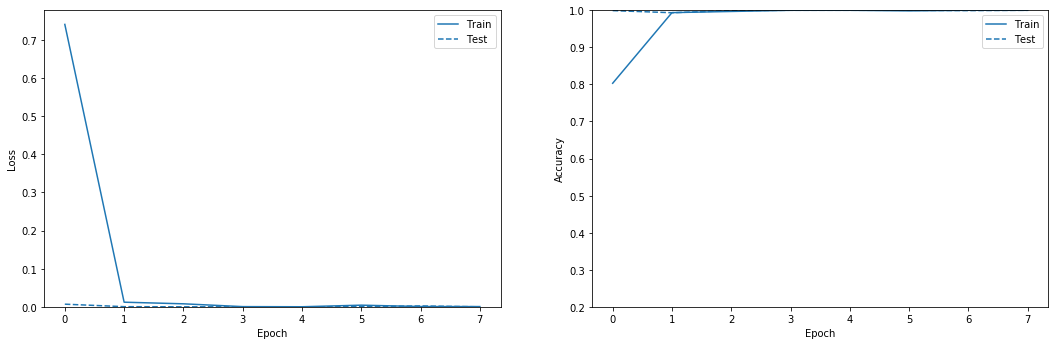

In [25]:
plot_metrics(results)

In [8]:
names = ['Marco' ,'Roberto']

In [168]:
cap = cv.VideoCapture(0)
# Acquisizione immagine
result, img = cap.read()
# Rilascio del dispositivo
cap.release()

In [169]:
b,g,r = cv.split(img)
img = cv.merge([r,g,b])
faces = face_detector.detectMultiScale(img)
#faces = faces.tolist()

for (x,y,w,h) in faces:
        face = img[y:y+h,x:x+h,:]

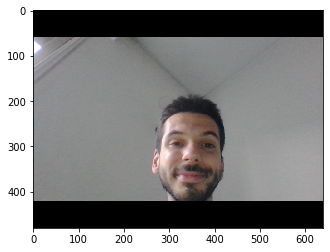

(<matplotlib.image.AxesImage at 0x29702aeb048>, None)

In [170]:
plt.imshow(img), plt.show()

In [178]:
img = mpimg.imread('roberto.jpg')

2


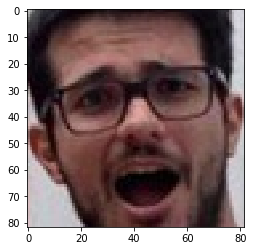

In [179]:
faces = face_detector.detectMultiScale(img)
#faces = faces.tolist()
print(len(faces))
for (x,y,w,h) in faces:
        face = img[y:y+h,x:x+h,:]
        
plt.imshow(face); plt.show()        

In [182]:
face

array([[[187, 187, 187],
        [163, 163, 163],
        [111, 111, 113],
        ...,
        [217, 216, 224],
        [212, 211, 219],
        [207, 206, 214]],

       [[170, 170, 170],
        [131, 131, 131],
        [ 87,  88,  90],
        ...,
        [213, 212, 220],
        [211, 210, 218],
        [209, 208, 216]],

       [[150, 150, 150],
        [ 95,  95,  95],
        [ 74,  75,  77],
        ...,
        [211, 210, 218],
        [212, 211, 219],
        [214, 213, 221]],

       ...,

       [[215, 192, 198],
        [205, 196, 199],
        [191, 189, 192],
        ...,
        [205, 193, 197],
        [202, 193, 198],
        [197, 191, 195]],

       [[217, 194, 200],
        [206, 197, 200],
        [192, 190, 193],
        ...,
        [206, 191, 194],
        [205, 194, 198],
        [193, 187, 191]],

       [[215, 192, 198],
        [205, 196, 199],
        [195, 193, 196],
        ...,
        [195, 179, 180],
        [207, 195, 197],
        [200, 191, 194]]

In [183]:
img_pixels = cv.resize(face, (224, 224)) 
img_pixels = kimage.img_to_array(img_pixels)
img_pixels = np.expand_dims(img_pixels, axis = 0)
img_pixels = vgg16.preprocess_input(img_pixels)
y_pred = net.predict(img_pixels)
y_pred_name = np.argmax(y_pred)
names[y_pred_name]

'?fdih?'

In [184]:
y_pred

array([[0.01114236, 0.03361465, 0.95524305]], dtype=float32)

In [121]:
net.save('mymodel_64ba.h5')

In [16]:
net = keras.models.load_model('mymodel_64ba.h5')

In [23]:
def process_frame(img):
    if img is not None:
        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        faces = face_detector.detectMultiScale(img_gray)
        if len(faces)>=1:
            (x,y,w,h) = faces[0]
            face = img[y:y+h, x:x+w, :]
            img_pixels = cv.resize(face, (224, 224)) 
            img_pixels = kimage.img_to_array(img_pixels)
            img_pixels = np.expand_dims(img_pixels, axis = 0)
            img_pixels = vgg16.preprocess_input(img_pixels)
            y_pred = net.predict(img_pixels)
            y_pred_name = np.argmax(y_pred)
            
            
            cv.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
            cv.putText(img, names[y_pred_name], org = (0, 185), fontScale = 1, fontFace = cv.FONT_HERSHEY_SIMPLEX, 
                       color = (0, 0, 255), thickness = 2 
                      )
    
    return img #di base valori da 0 e 1, se metto 1 - ho l'inverso

In [24]:
cap = cv.VideoCapture(0)
while(True): # while infinito
    # Acquisizione nuovo frame
    r, frame = cap.read() #catturiamo un elemento
    # Elaborazione del contenuto
    frame = process_frame(frame) # ci si fa qualcosa (es quello per il progetto)
    # Visualizzazione esterna
    cv.imshow('Video', frame) #apre ina nuova finestra con il contenuto di quello che abbbiamo
    # Interruzione alla pressione del tasto Q
    if cv.waitKey(20) & 0xFF == ord('q'):
        break
cap.release() #rilascio il dispositivo
cv.destroyAllWindows() #chido la finestra